In [1]:
import nflgame
import matplotlib.pyplot as plt

# returns the field position as the number of yards away from the opposing team's end zone
def field_pos_to_number(pos):
    pos = pos.split(" ")
    if pos[0] == "MIDFIELD":
        return 50
    elif pos[0] == "OWN":
        return 100-int(pos[1])
    elif pos[0] == "OPP":
        return int(pos[1])
    
# returns the current game clock as a quarter, clock tuple
def clock_to_nums(clock):
    clock = clock.split(" ")
    clock[0] = min(int(clock[0][1:]), 5)
    return clock[0], clock[1]

# returns the current play in a different format
def convert_play(p):
    quarter, time = clock_to_nums(p[2])
    return [quarter, time, p[3], p[4], field_pos_to_number(p[5]), p[-5], p[-4], p[-3], p[-2], p[-1]]
    
# get number of points scored on the conversion attempt after a touchdown
def get_conversion(plays, scores, i):
    # use list of scoring plays to figure out conversions
    if i < len(scores):
        #print(scores[i])
        if " TD " in scores[i]:
            if "failed" in scores[i]:
                return 0, i+1
            if "kick is good" in scores[i]:
                return 1, i+1
            if "run)" in scores[i] or "pass)" in scores[i]:
                return 2, i+1
            if i < len(scores)-1 and "defensive two point conversion" in scores[i+1]:
                return -1, i+2
    return 0, i+1

# get all plays for a given game in the proper format
def get_all_plays2(game, spread):   
    plays = nflgame.combine_plays([game])
    scores = game.scores
    score_index = 0
    home = 0
    away = 0
    win = (game.score_home >= game.score_away)
    plays2 = []
    for p in plays:
        plays2.append(p)

    all_plays = []
    for i in range(len(plays2)):
        p = plays2[i]
        if (p.down > 0 and str(p.time) != "None" and str(p.yardline) != "None"): # or p.note == "KICKOFF":
            # add play to all plays
            temp_play = [game.home, game.away, str(p.time), p.down, p.yards_togo, 
                         str(p.yardline), p.home, home, away, spread, win]
            all_plays.append(convert_play(temp_play))
#         if (not p.note == None) and len(p.note) >= 2 and (p.note[:2] == "2P" or p.note[:2] == "XP"):
#             print(p.note)
        # do scoring stuff
        if p.note == "TD":
            pts = 6
            is_home = p.home
            if p.punting_tot == 1:
                is_home = (not is_home)
            if p.defense_tds == 1:
                is_home = (not is_home)
#             is_home = True
#             if (not p.home and p.defense_tds != 1) or (p.home and p.defense_tds == 1):
#                 is_home = False
            conv, score_index = get_conversion(plays2, scores, score_index)
            # add conversion points if it wasn't a defensive 2 point conversion
            if conv != -1:
                pts += conv
            if is_home:
                home += pts
            else:
                away += pts
            # handle defensive 2 point conversion 
            if conv == -1:
                if is_home:
                    away += 2
                else:
                    home += 2
            #print(str(home) + "-" + str(away))

        elif p.note == "FG":
            if p.home:
                home += 3
            else:
                away += 3
            score_index += 1
                
        elif p.note == "SAF":
            if scores[score_index].split("-")[0][:-1] == str(game.home):
                home += 2
            else:
                away += 2
            score_index += 1

    return home, away, all_plays

def fix_name(t):
    if t == "SD":
        t = "LAC"
    if t == "LA" or t == "STL":
        t = "LAR"
    if t == "JAC":
        t = "JAX"
    return t
    
# get all plays from all weeks in weeks and all seasons in years. calls get_all_plays2
def get_plays(years, weeks, indexes=-1):
    all_plays = []
    for y in years:
        print(y)
        for w in weeks:
            #print(w)
            try:
                games = nflgame.games(y, week=w, kind='REG')
            except:
                continue
            current = data[(data["schedule_season"] == y) & (data["schedule_week"] == str(w))]
            if not indexes == -1:
                games = [games[i] for i in indexes]
            for g in games:
                t1 = g.home
                t2 = g.away
                t1 = fix_name(t1)
                t2 = fix_name(t2)
                #print(t2)
                spread = list(current.loc[(current["team1"] == t1) & (current["team2"] == t2)]["vegas_spread"])
                if len(spread) > 0:
                    h, a, cur_plays = get_all_plays2(g, spread[0])
                    if h != g.score_home or a != g.score_away:
                        #print("Actual: " + str(g.score_home) + "-" + str(g.score_away) + ", Mine: " + str(h) + "-" + 
                          #    str(a) + " " + str(g.home) + " " +str(g.away))
                        continue
                    all_plays += cur_plays
    return all_plays

# final model?
def collect_plays(all_plays):
    # collect plays and add interaction terms
    x_data = []
    y_data = []
    for p in all_plays:
        qtr = p[0]
        time = p[1].split(":")
        if len(time[0]) == 0:
            continue
        mins_left = 15*(4-min(qtr,4))+int(time[0])
        secs_left = int(time[1])
        time_left = round(mins_left + secs_left/60.,2)

        x_data.append([time_left]+p[2:-1])
        y_data.append(1 if p[-1] else 0)

    df = pd.DataFrame(x_data, columns=["time", "down", "distance", "fieldpos", "homeposs", "score_home", 
                                      "score_away", "spread"])

    
    df["last5"] = df["time"].apply(lambda x : 1 if x <= 5 else 0)
    
    # basic terms
    df["scorediff"] = (df["score_home"] - df["score_away"])
    df["down1"] = df["down"].apply(lambda x : 1 if x == 1 else 0)
    df["down2"] = df["down"].apply(lambda x : 1 if x == 2 else 0)
    df["down3"] = df["down"].apply(lambda x : 1 if x == 3 else 0)
    df["down4"] = df["down"].apply(lambda x : 1 if x == 4 else 0)
    df["homeposs"] = df["homeposs"].apply(lambda x : 1 if x else 0)
    
    # interaction terms
    df["down1*poss"] = df["down1"] * df["homeposs"] * (1-df["last5"])
    df["down2*poss"] = df["down2"] * df["homeposs"] * (1-df["last5"])
    df["down3*poss"] = df["down3"] * df["homeposs"] * (1-df["last5"])
    df["down4*poss"] = df["down4"] * df["homeposs"] * (1-df["last5"])
    df["distance*poss"] = df["distance"] * df["homeposs"] * (1-df["last5"])
    df["fieldpos*poss"] = df["fieldpos"] * df["homeposs"] * (1-df["last5"])
    
    # time dependent stuff
    # basic terms
    df["scorediff_time"] = (df["score_home"] - df["score_away"]) * df["last5"]
    df["down1_time"] = df["down"].apply(lambda x : 1 if x == 1 else 0) * df["last5"]
    df["down2_time"] = df["down"].apply(lambda x : 1 if x == 2 else 0) * df["last5"]
    df["down3_time"] = df["down"].apply(lambda x : 1 if x == 3 else 0) * df["last5"]
    df["down4_time"] = df["down"].apply(lambda x : 1 if x == 4 else 0) * df["last5"]
    
    # interaction terms
    df["down1*poss_time"] = df["down1"] * df["homeposs"] * df["last5"]
    df["down2*poss_time"] = df["down2"] * df["homeposs"] * df["last5"]
    df["down3*poss_time"] = df["down3"] * df["homeposs"] * df["last5"]
    df["down4*poss_time"] = df["down4"] * df["homeposs"] * df["last5"]
    df["distance*poss_time"] = df["distance"] * df["homeposs"] * df["last5"]
    df["fieldpos*poss_time"] = df["fieldpos"] * df["homeposs"] * df["last5"]
    
    # more interaction terms
    df["time*poss"] = (60-df["time"]) * df["homeposs"]
    df["time*spread"] = df["time"] * df["spread"]
    df["time*scorediff"] = (60-df["time"]) * df["scorediff"]
    df["fgrange"] = df["fieldpos"].apply(lambda x : 1 if x <= 35 else 0)
    df["fgrange*poss"] = df["fgrange"] * df["homeposs"]

    # additional terms
    df["close"] = df["scorediff"].apply(lambda x : 1 if abs(x) <= 8 else 0)
    df["last5min_close"] = df["last5"] * df["close"]
    df["last5min_close_poss"] = df["last5min_close"] * df["homeposs"]
    
    # fix basic terms
    df["scorediff"] *= (1-df["last5"])
    df["down1"] *= (1-df["last5"])
    df["down2"] *= (1-df["last5"])
    df["down3"] *= (1-df["last5"])
    df["down4"] *= (1-df["last5"])
    df["homeposs"] *= (1-df["last5"])
    
    # score correction
    df["sqrt_time"] = df["time"].apply(lambda x : 1 + np.sqrt(x))
    df["score_correction"] = df["scorediff"] / df["sqrt_time"]
    
    df.drop(["score_correction", "homeposs", "down", "score_home", "score_away", "last5", 
             "close", "sqrt_time", "last5min_close", "last5min_close_poss"], axis=1, inplace=True)
    
    return df, y_data

def remove_features(df):
    df.drop(["time*poss", "time*spread", "time*scorediff", "fgrange", "fgrange*poss"], axis=1, inplace=True)
    return df

def check_wp(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

def check_wp2(x, y, model, threshold):
    y_pred = model.predict(x)
    time_left = list(x["time"])
    
    results = []
    for i in range(len(y_pred)):
        if time_left[i] > 5:
            continue
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

# check accuracy using original mse thing
def check_model_accuracy(test_x, test_y, model, last5):
    x = np.arange(0,1.01,0.05)
    y = []
    ses = []
    se = 0
    for i in x:
        if not last5:
            cur_mean, cur_se = check_wp(test_x, test_y, model, i)
        else:
            cur_mean, cur_se = check_wp2(test_x, test_y, model, i)
        y.append(cur_mean)
        ses.append(cur_se)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)) + ", SE = " + str(round(cur_se, 3)))
        se += (cur_mean-i)**2

    print("")
    print("mse: " + str(se/len(x)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy2(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_se, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        se += cur_se
        count += cur_num

    print("")
    print("brier score: " + str(se/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
def get_brier(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    errors = []
    
    y_pred = list(y_pred)
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.025:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
            errors.append((y[i]-y_pred[i])**2)
    #print(count)
    return np.mean(results), sum(errors), len(errors)

# check accuracy using the brier score
def check_model_accuracy_all(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times_pca(old_old_test_x, old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_old_test_x["time"] <= start_time) & 
                               (old_old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()

# check accuracy using the brier score and does the binary prediction thing
def check_model_accuracy_times2(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num
        
    # do binary thing
    y_pred = model.predict(test_x)
    b_y_pred = [1 if val > 0.5 else 0 for val in y_pred]
    correct = 0
    for i in range(len(b_y_pred)):
        if b_y_pred[i] == test_y[i]:
            correct += 1

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))
    print("binary prediction accuracy: " + str(correct/len(b_y_pred)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    fig = plt.gcf()
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    return fig

Updating (2019, 'POST', 22)
Week POST22 of 2019 was either empty, or it couldn't be fetched from NFL.com. Aborting.


In [15]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# get spread data
data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

# get training and testing data
train_fraction = 0.7

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = get_plays(years,weeks)

x_data, y_data = collect_plays(plays)

# convert to lists, randomize
cols = list(x_data)
x_data = x_data.values.tolist()
alldata = list(zip(x_data, y_data))
random.shuffle(alldata)
x_data, y_data = zip(*alldata)
x_data = list(x_data)
y_data = list(y_data)

# simpler model
x_data2 = pd.DataFrame(data=np.array(x_data), columns=cols)
x_data2 = remove_features(x_data2)
cols2 = list(x_data2)
x_data2 = x_data2.values.tolist()

# take the appropriate training and testing sets
num_points = int(train_fraction*len(x_data))
train_x = pd.DataFrame(x_data[:num_points], columns=cols)
train_y = y_data[:num_points]
test_x = pd.DataFrame(x_data[num_points:], columns=cols)
test_y = y_data[num_points:]

# training and testing for simpler model
train_x2 = pd.DataFrame(x_data2[:num_points], columns=cols2)
test_x2 = pd.DataFrame(x_data2[num_points:], columns=cols2)

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [16]:
x_data, y_data = collect_plays(plays)

# convert to lists, randomize
cols = list(x_data)
x_data = x_data.values.tolist()
alldata = list(zip(x_data, y_data))
random.shuffle(alldata)
x_data, y_data = zip(*alldata)
x_data = list(x_data)
y_data = list(y_data)

# simpler model
x_data2 = pd.DataFrame(data=np.array(x_data), columns=cols)
x_data2 = remove_features(x_data2)
cols2 = list(x_data2)
x_data2 = x_data2.values.tolist()

# take the appropriate training and testing sets
num_points = int(train_fraction*len(x_data))
train_x = pd.DataFrame(x_data[:num_points], columns=cols)
train_y = y_data[:num_points]
test_x = pd.DataFrame(x_data[num_points:], columns=cols)
test_y = y_data[num_points:]

# training and testing for simpler model
train_x2 = pd.DataFrame(x_data2[:num_points], columns=cols2)
test_x2 = pd.DataFrame(x_data2[num_points:], columns=cols2)

In [17]:
logit_model=sm.Logit(train_y, train_x2)
result=logit_model.fit()
logit_model=sm.Logit(train_y, train_x)
result2=logit_model.fit()

print(result.summary2())
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.450093
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.445871
         Iterations 8
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.340      
Dependent Variable:   y                AIC:              236847.9252
Date:                 2020-04-05 10:48 BIC:              237120.4080
No. Observations:     263052           Log-Likelihood:   -1.1840e+05
Df Model:             25               LL-Null:          -1.7936e+05
Df Residuals:         263026           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       9.0000                                        
--------------------------------------------------------------------
                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------

simplified logistic full game
0.0: 0.0
0.05: 0.032
0.1: 0.102
0.15: 0.161
0.2: 0.225
0.25: 0.252
0.3: 0.308
0.35: 0.364
0.4: 0.4
0.45: 0.458
0.5: 0.485
0.55: 0.541
0.6: 0.598
0.65: 0.652
0.7: 0.694
0.75: 0.766
0.8: 0.807
0.85: 0.839
0.9: 0.89
0.95: 0.956
1.0: 1.0

mse: 0.00011173953170008195
brier score: 0.14178822158472504


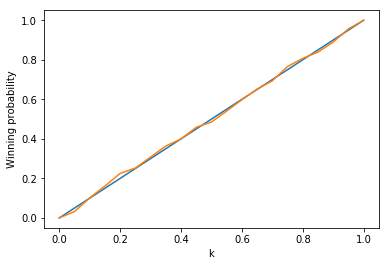

simplified logistic last 5
0.0: 0.0
0.05: 0.048
0.1: 0.07
0.15: 0.167
0.2: 0.216
0.25: 0.254
0.3: 0.379
0.35: 0.341
0.4: 0.323
0.45: 0.444
0.5: 0.56
0.55: 0.487
0.6: 0.478
0.65: 0.631
0.7: 0.743
0.75: 0.689
0.8: 0.76
0.85: 0.818
0.9: 0.876
0.95: 0.954
1.0: 1.0

mse: 0.0021533673598505146
brier score: 0.05872566463684727


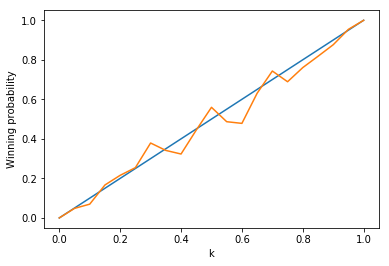

full logistic full game
0.0: 0.0
0.05: 0.034
0.1: 0.102
0.15: 0.145
0.2: 0.202
0.25: 0.239
0.3: 0.298
0.35: 0.343
0.4: 0.409
0.45: 0.439
0.5: 0.483
0.55: 0.541
0.6: 0.597
0.65: 0.656
0.7: 0.686
0.75: 0.758
0.8: 0.801
0.85: 0.852
0.9: 0.888
0.95: 0.947
1.0: 1.0

mse: 7.252326674216545e-05
brier score: 0.13720714805458642


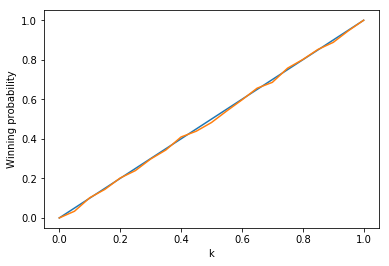

full logistic last 5
0.0: 0.0
0.05: 0.047
0.1: 0.105
0.15: 0.113
0.2: 0.132
0.25: 0.269
0.3: 0.298
0.35: 0.429
0.4: 0.306
0.45: 0.482
0.5: 0.478
0.55: 0.438
0.6: 0.577
0.65: 0.67
0.7: 0.721
0.75: 0.706
0.8: 0.796
0.85: 0.851
0.9: 0.874
0.95: 0.963
1.0: 1.0

mse: 0.0018916416124717854
brier score: 0.05810980502766544


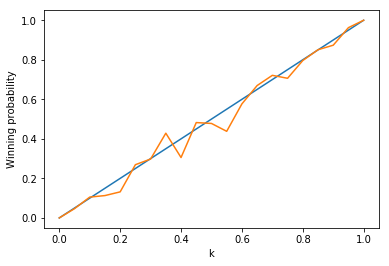

In [4]:
print("simplified logistic full game")
check_model_accuracy_times(test_x2, test_y, result, 60, 0)

print("simplified logistic last 5")
check_model_accuracy_times(test_x2, test_y, result, 5, 0)

print("full logistic full game")
check_model_accuracy_times(test_x, test_y, result2, 60, 0)

print("full logistic last 5")
check_model_accuracy_times(test_x, test_y, result2, 5, 0)

### comparing with pelechrinis

simplified logistic full game
0.0: 0.0
0.05: 0.032
0.1: 0.102
0.15: 0.161
0.2: 0.225
0.25: 0.252
0.3: 0.308
0.35: 0.364
0.4: 0.4
0.45: 0.458
0.5: 0.485
0.55: 0.541
0.6: 0.598
0.65: 0.652
0.7: 0.694
0.75: 0.766
0.8: 0.807
0.85: 0.839
0.9: 0.89
0.95: 0.956
1.0: 1.0

mse: 0.00011173953170008195
brier score: 0.14178822158472504
binary prediction accuracy: 0.7780764079228647


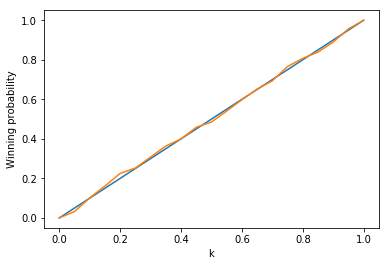

simplified logistic last 5
0.0: 0.0
0.05: 0.048
0.1: 0.07
0.15: 0.167
0.2: 0.216
0.25: 0.254
0.3: 0.379
0.35: 0.341
0.4: 0.323
0.45: 0.444
0.5: 0.56
0.55: 0.487
0.6: 0.478
0.65: 0.631
0.7: 0.743
0.75: 0.689
0.8: 0.76
0.85: 0.818
0.9: 0.876
0.95: 0.954
1.0: 1.0

mse: 0.0021533673598505146
brier score: 0.05872566463684727


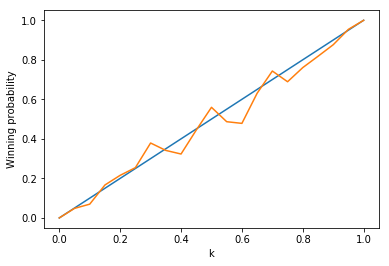

full logistic full game
0.0: 0.0
0.05: 0.034
0.1: 0.102
0.15: 0.145
0.2: 0.202
0.25: 0.239
0.3: 0.298
0.35: 0.343
0.4: 0.409
0.45: 0.439
0.5: 0.483
0.55: 0.541
0.6: 0.597
0.65: 0.656
0.7: 0.686
0.75: 0.758
0.8: 0.801
0.85: 0.852
0.9: 0.888
0.95: 0.947
1.0: 1.0

mse: 7.252326674216545e-05
brier score: 0.13720714805458642
binary prediction accuracy: 0.77904325997676


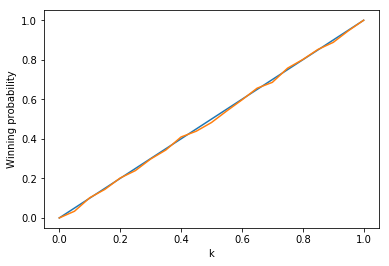

full logistic last 5
0.0: 0.0
0.05: 0.047
0.1: 0.105
0.15: 0.113
0.2: 0.132
0.25: 0.269
0.3: 0.298
0.35: 0.429
0.4: 0.306
0.45: 0.482
0.5: 0.478
0.55: 0.438
0.6: 0.577
0.65: 0.67
0.7: 0.721
0.75: 0.706
0.8: 0.796
0.85: 0.851
0.9: 0.874
0.95: 0.963
1.0: 1.0

mse: 0.0018916416124717854
brier score: 0.05810980502766544


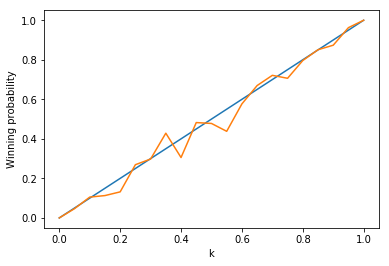

In [7]:
print("simplified logistic full game")
check_model_accuracy_times2(test_x2, test_y, result, 60, 0)

print("simplified logistic last 5")
check_model_accuracy_times(test_x2, test_y, result, 5, 0)

print("full logistic full game")
check_model_accuracy_times2(test_x, test_y, result2, 60, 0)

print("full logistic last 5")
check_model_accuracy_times(test_x, test_y, result2, 5, 0)

simplified logistic full game
0.0: 0.006
0.05: 0.033
0.1: 0.092
0.15: 0.161
0.2: 0.219
0.25: 0.265
0.3: 0.309
0.35: 0.381
0.4: 0.411
0.45: 0.457
0.5: 0.488
0.55: 0.544
0.6: 0.597
0.65: 0.647
0.7: 0.7
0.75: 0.762
0.8: 0.794
0.85: 0.842
0.9: 0.886
0.95: 0.954
1.0: 0.993

mse: 0.00014547483786127855
brier score: 0.14995707385584947
binary prediction accuracy: 0.7755927512706565


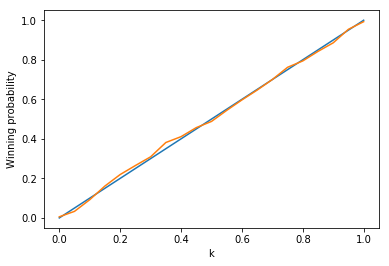

simplified logistic last 5
0.0: 0.003
0.05: 0.03
0.1: 0.106
0.15: 0.168
0.2: 0.204
0.25: 0.29
0.3: 0.384
0.35: 0.372
0.4: 0.406
0.45: 0.515
0.5: 0.476
0.55: 0.538
0.6: 0.577
0.65: 0.576
0.7: 0.725
0.75: 0.769
0.8: 0.778
0.85: 0.81
0.9: 0.814
0.95: 0.933
1.0: 0.995

mse: 0.001506853500644515
brier score: 0.08748046998476816
binary prediction accuracy: 0.8728397019185032


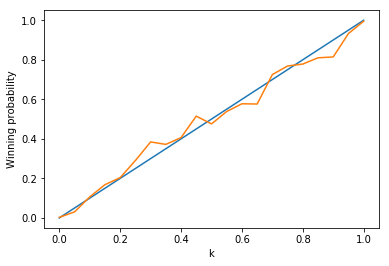

full logistic full game
0.0: 0.004
0.05: 0.035
0.1: 0.094
0.15: 0.155
0.2: 0.218
0.25: 0.273
0.3: 0.326
0.35: 0.368
0.4: 0.417
0.45: 0.443
0.5: 0.505
0.55: 0.537
0.6: 0.592
0.65: 0.648
0.7: 0.707
0.75: 0.755
0.8: 0.794
0.85: 0.841
0.9: 0.891
0.95: 0.951
1.0: 0.994

mse: 0.0001448810998962813
brier score: 0.14870989428122813
binary prediction accuracy: 0.7773047003202143


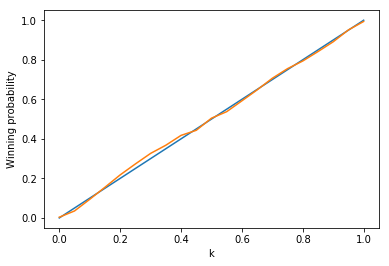

full logistic last 5
0.0: 0.002
0.05: 0.024
0.1: 0.104
0.15: 0.123
0.2: 0.174
0.25: 0.278
0.3: 0.361
0.35: 0.37
0.4: 0.361
0.45: 0.484
0.5: 0.5
0.55: 0.529
0.6: 0.592
0.65: 0.652
0.7: 0.714
0.75: 0.764
0.8: 0.769
0.85: 0.856
0.9: 0.833
0.95: 0.943
1.0: 0.996

mse: 0.0007684588703507983
brier score: 0.08561156267945239
binary prediction accuracy: 0.8763278896464246


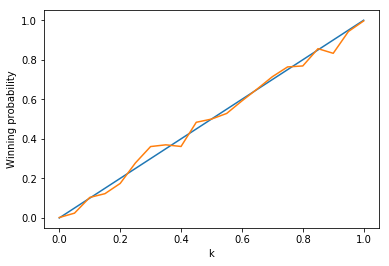

In [6]:
# with bins
print("simplified logistic full game")
fig = check_model_accuracy_times2(test_x2, test_y, result, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic_time/randomsplits/simplified_60.png")

print("simplified logistic last 5")
fig = check_model_accuracy_times2(test_x2, test_y, result, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic_time/randomsplits/simplified_5.png")

print("full logistic full game")
fig = check_model_accuracy_times2(test_x, test_y, result2, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic_time/randomsplits/full_60.png")

print("full logistic last 5")
fig = check_model_accuracy_times2(test_x, test_y, result2, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic_time/randomsplits/full_5.png")

## cross validation, splitting by season

In [7]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# get spread data
data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

# get training and testing data
test_fraction = 0.3

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = []
for y in years:
    plays.append(get_plays([y],weeks))

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [8]:
x_data = []
y_data = []
for i in range(len(plays)):
    x_data_cur, y_data_cur = collect_plays(plays[i])
    x_data.append(x_data_cur)
    y_data.append(y_data_cur)
    
train_x = []
test_x = []
train_y = []
test_y = []

for i in range(len(x_data)):
    cur_x = pd.concat([x_data[j] for j in range(len(x_data)) if j != i])
    cur_y = [y_data[j] for j in range(len(y_data)) if j != i]
    cur_y = [val for ylist in cur_y for val in ylist]
    train_x.append(cur_x)
    train_y.append(cur_y)
    test_x.append(x_data[i])
    test_y.append(y_data[i])

cols = list(train_x[0])
train_x2 = []
test_x2 = []
for i in range(len(train_x)):
    temp = pd.DataFrame(data=np.array(train_x[i]), columns=cols)
    train_x2.append(remove_features(temp))
    temp2 = pd.DataFrame(data=np.array(test_x[i]), columns=cols)
    test_x2.append(remove_features(temp2))


In [10]:
# check accuracy using the brier score
def check_model_accuracy_times3(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    counts = []
    means = []
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean * cur_num)
        brier += cur_brier
        counts.append(cur_num)

    return y, brier, counts

In [14]:
means1 = []
briers1 = []
means2 = []
briers2 = []
counts1 = [0 for i in range(21)]
counts2 = [0 for i in range(21)]
cv_means1 = []
cv_means2 = []
cv_briers1 = []
cv_briers2 = []

for i in range(len(train_x)):
    print(i)
    logit_model=sm.Logit(train_y[i], train_x[i])
    result=logit_model.fit()
    
    cur_means, cur_brier, cur_count = check_model_accuracy_times3(test_x[i], test_y[i], result, 60, 0)
    means1.append(cur_means)
    briers1.append(cur_brier)
    counts1 = list(np.array(counts1) + np.array(cur_count))
    cv_means1.append(list(np.divide(np.array(cur_means), np.array(cur_count))))
    cv_briers1.append(cur_brier / sum(cur_count))
    
    logit_model=sm.Logit(train_y[i], train_x2[i])
    result2=logit_model.fit()
    
    cur_means, cur_brier, cur_count = check_model_accuracy_times3(test_x2[i], test_y[i], result2, 60, 0)
    means2.append(cur_means)
    briers2.append(cur_brier)
    counts2 = list(np.array(counts2) + np.array(cur_count))
    cv_means2.append(list(np.divide(np.array(cur_means), np.array(cur_count))))
    cv_briers2.append(cur_brier / sum(cur_count))

0
Optimization terminated successfully.
         Current function value: 0.448842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.452669
         Iterations 8
1
Optimization terminated successfully.
         Current function value: 0.447119
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.451318
         Iterations 8
2
Optimization terminated successfully.
         Current function value: 0.443935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.447958
         Iterations 8
3
Optimization terminated successfully.
         Current function value: 0.446527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.450675
         Iterations 9
4
Optimization terminated successfully.
         Current function value: 0.445308
         Iterations 8
Optimization terminated successfully.
         Current function value: 0

full model

average mse: 0.0016243404517787454
average brier score: 0.1484743307456889

simplified model

average mse: 0.0016409337179698886
average brier score: 0.14970034024023213

full model graphs
2009
mse: 0.001962992351072252
brier: 0.14087134488607173


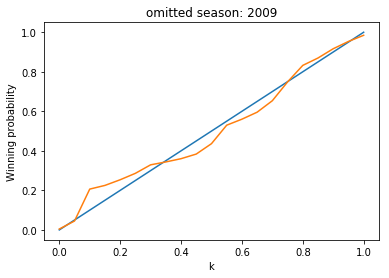

2010
mse: 0.0012950800560595167
brier: 0.14737612879162656


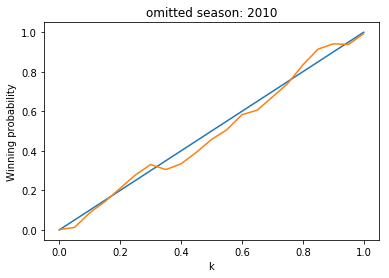

2011
mse: 0.0034016045168692543
brier: 0.15977034425610281


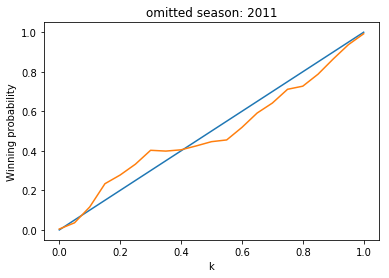

2012
mse: 0.0014961811618371163
brier: 0.15020391862258592


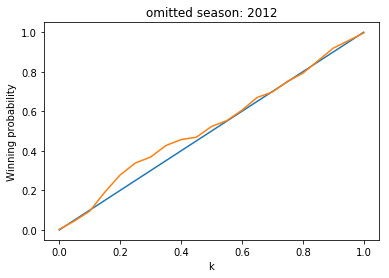

2013
mse: 0.0009856567905099061
brier: 0.1538388700839568


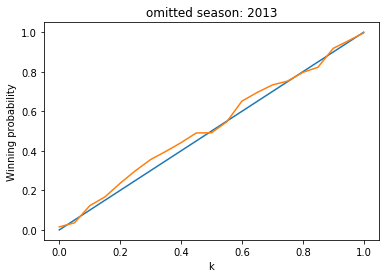

2014
mse: 0.0005794907378240143
brier: 0.14553854661148646


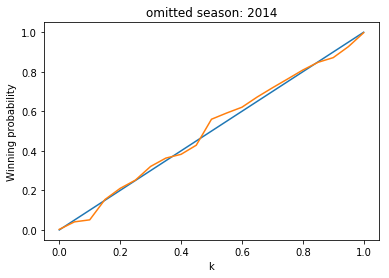

2015
mse: 0.0017163383414954057
brier: 0.15834104777489927


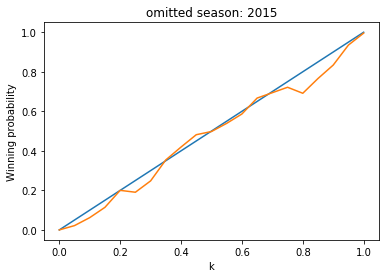

2016
mse: 0.0007535905820452819
brier: 0.15397579961253713


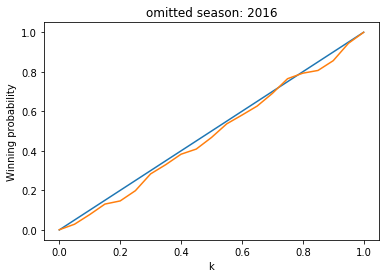

2017
mse: 0.002403751838738271
brier: 0.13077335714889995


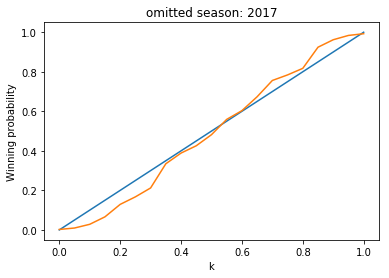

2018
mse: 0.0016487181413364364
brier: 0.14405394966872231


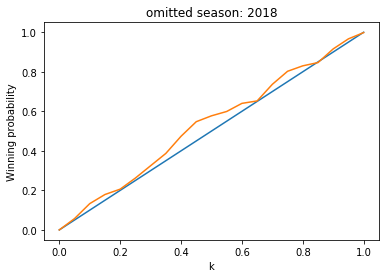


simplified model graphs
2009
mse: 0.0023133741623476765
brier: 0.14259748838122677


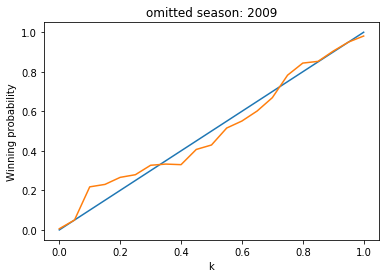

2010
mse: 0.0009880198804843917
brier: 0.1486023123381384


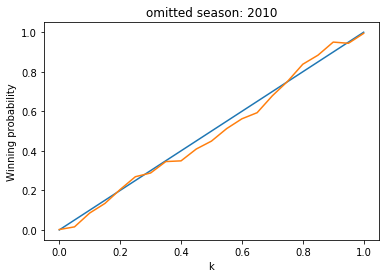

2011
mse: 0.0032488676095819014
brier: 0.16143040449534554


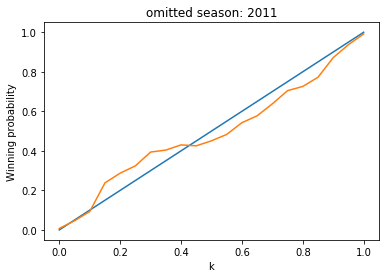

2012
mse: 0.0014328050569735189
brier: 0.15123533060400257


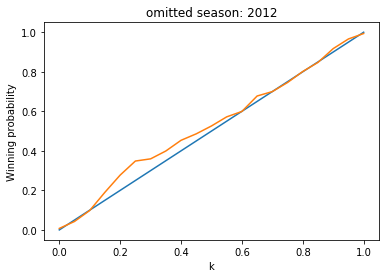

2013
mse: 0.0010276599651068952
brier: 0.15570892426636118


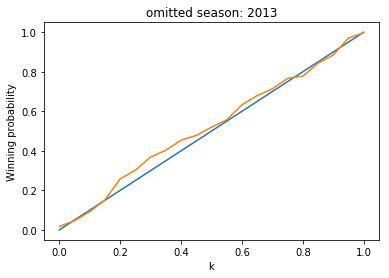

2014
mse: 0.0006757540324730147
brier: 0.14731723177220996


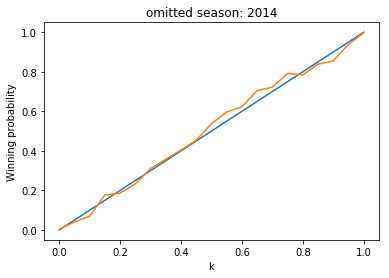

2015
mse: 0.0014540920189619905
brier: 0.1590936452991932


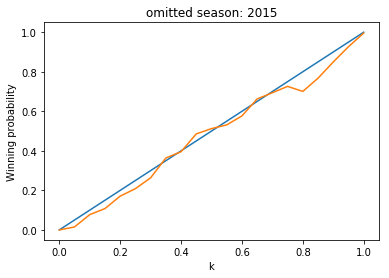

2016
mse: 0.0008928860089294256
brier: 0.15551669059668044


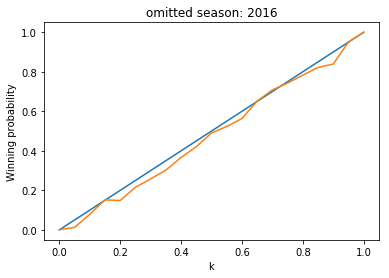

2017
mse: 0.002655964649490288
brier: 0.13148424819208376


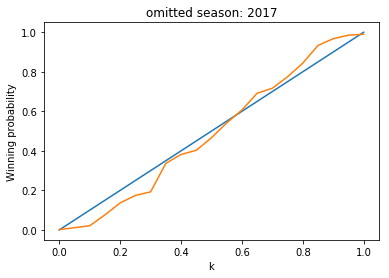

2018
mse: 0.0017199137953497836
brier: 0.14401712645707956


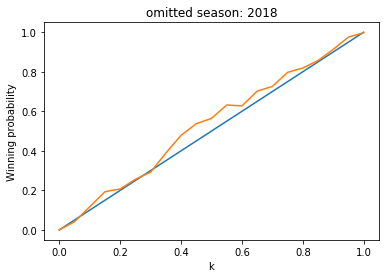

In [15]:
# model 1
x = np.arange(0, 1.01, 0.05)

print("full model")
ses1 = 0
for i in range(len(cv_means1)):
    ses1 += sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)
    
print("")
print("average mse: " + str(ses1/len(cv_means1)))
print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))

print("")
print("simplified model")
ses2 = 0
for i in range(len(cv_means2)):
    ses2 += sum([(cv_means2[i][j]-x[j])**2 for j in range(len(x))]) / len(x)
    
    
print("")
print("average mse: " + str(ses2/len(cv_means2)))
print("average brier score: " + str(sum(cv_briers2)/len(cv_briers2)))

print("")
print("full model graphs")
for i in range(len(cv_means1)):
    print(years[i])
    print("mse: " + str(sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
    print("brier: " + str(cv_briers1[i]))
    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,cv_means1[i])
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    plt.title("omitted season: " + str(years[i]))
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
print("")
print("simplified model graphs")
for i in range(len(cv_means2)):
    print(years[i])
    print("mse: " + str(sum([(cv_means2[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
    print("brier: " + str(cv_briers2[i]))
    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,cv_means2[i])
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    plt.title("omitted season: " + str(years[i]))
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()

In [40]:
means1 = []
briers1 = []
means2 = []
briers2 = []
counts1 = [0 for i in range(21)]
counts2 = [0 for i in range(21)]
cv_means1 = []
cv_means2 = []
cv_briers1 = []
cv_briers2 = []

for i in range(len(train_x)):
    print(i)
    logit_model=sm.Logit(train_y[i], train_x[i])
    result=logit_model.fit()
    
    cur_means, cur_brier, cur_count = check_model_accuracy_times2(test_x[i], test_y[i], result, 5, 0)
    means1.append(cur_means)
    briers1.append(cur_brier)
    counts1 = list(np.array(counts1) + np.array(cur_count))
    cv_means1.append(list(np.divide(np.array(cur_means), np.array(cur_count))))
    cv_briers1.append(cur_brier / sum(cur_count))
    
    logit_model=sm.Logit(train_y[i], train_x2[i])
    result2=logit_model.fit()
    
    cur_means, cur_brier, cur_count = check_model_accuracy_times2(test_x2[i], test_y[i], result2, 5, 0)
    means2.append(cur_means)
    briers2.append(cur_brier)
    counts2 = list(np.array(counts2) + np.array(cur_count))
    cv_means2.append(list(np.divide(np.array(cur_means), np.array(cur_count))))
    cv_briers2.append(cur_brier / sum(cur_count))

0
Optimization terminated successfully.
         Current function value: 0.448842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.452669
         Iterations 8
1
Optimization terminated successfully.
         Current function value: 0.447119
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.451318
         Iterations 8
2
Optimization terminated successfully.
         Current function value: 0.443935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.447958
         Iterations 8
3
Optimization terminated successfully.
         Current function value: 0.446527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.450675
         Iterations 9
4
Optimization terminated successfully.
         Current function value: 0.445308
         Iterations 8
Optimization terminated successfully.
         Current function value: 0

full model

average mse: 0.007064619419267176
average brier score: 0.060313702885016286

simplified model

average mse: 0.008146945858402354
average brier score: 0.06003986560828341

full model graphs
2009
mse: 0.008188729179477845
brier: 0.053135205355405904


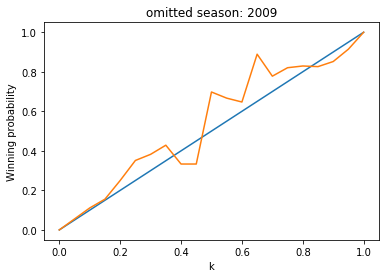

2010
mse: 0.004182180201917993
brier: 0.05538543484778335


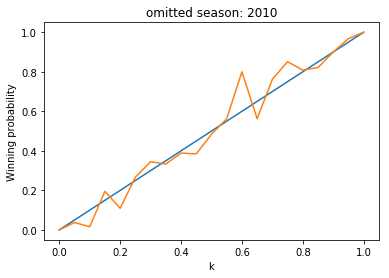

2011
mse: 0.007092601895117135
brier: 0.059065402034883


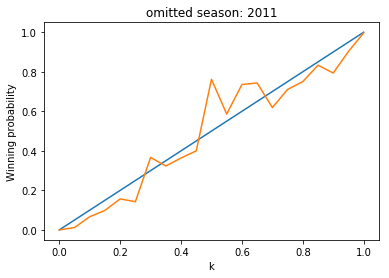

2012
mse: 0.01040506693021017
brier: 0.06874895325440085


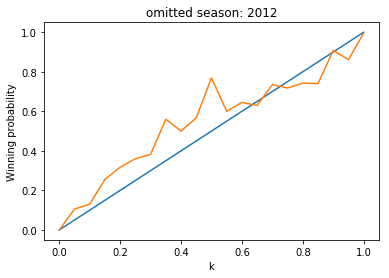

2013
mse: 0.006596721592733892
brier: 0.06302185252210747


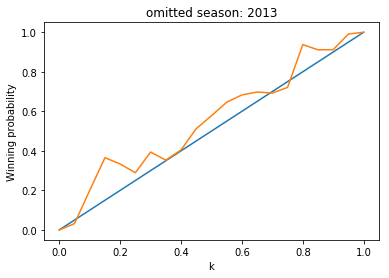

2014
mse: 0.009335509750917199
brier: 0.04953393005506777


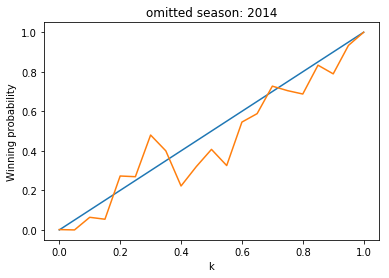

2015
mse: 0.006928837239125453
brier: 0.07043078580277119


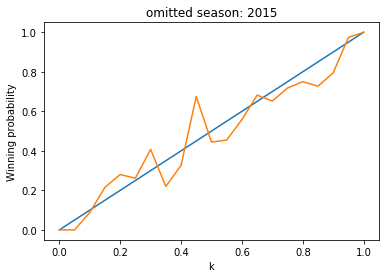

2016
mse: 0.004845347965448339
brier: 0.06658218668779625


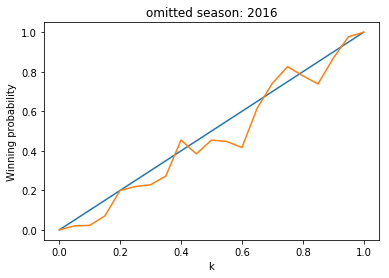

2017
mse: 0.006106550785578502
brier: 0.04835241043181052


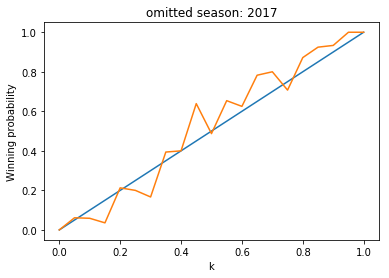

2018
mse: 0.006964648652145231
brier: 0.06888086785813649


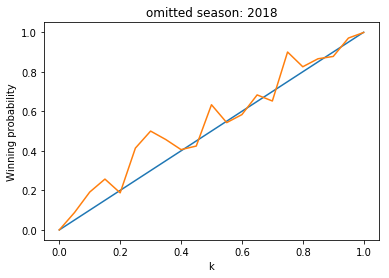


simplified model graphs
2009
mse: 0.009322849970012904
brier: 0.056057032949294774


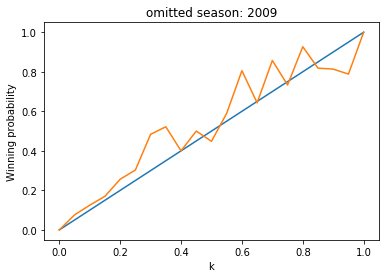

2010
mse: 0.0027172304082123643
brier: 0.05835959995430904


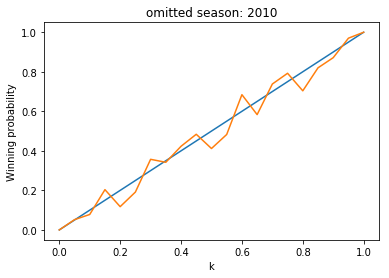

2011
mse: 0.006082916071160847
brier: 0.05811732172006974


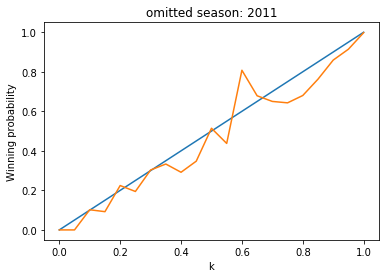

2012
mse: 0.00979777619792668
brier: 0.0657441160553349


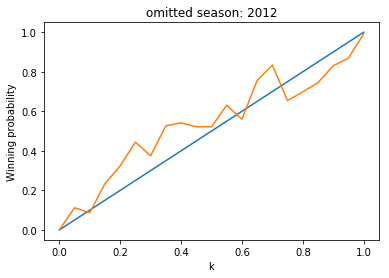

2013
mse: 0.01007318073652848
brier: 0.06251284844719272


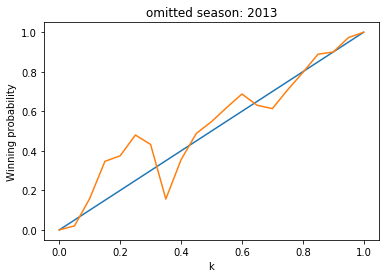

2014
mse: 0.012272239232154262
brier: 0.048618681253827865


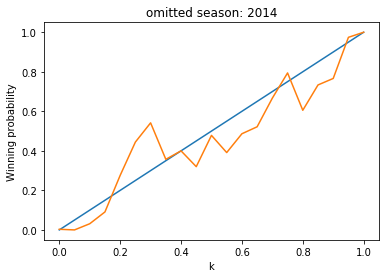

2015
mse: 0.0040004171903465155
brier: 0.06652052290378073


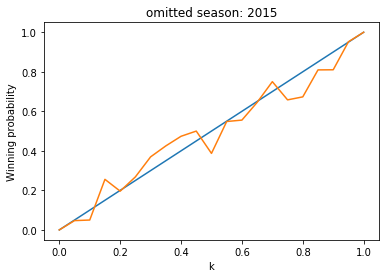

2016
mse: 0.004315691870933757
brier: 0.06654119718754008


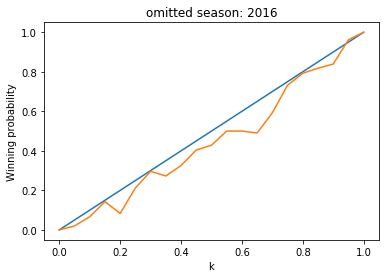

2017
mse: 0.008143876218382584
brier: 0.05020224603284547


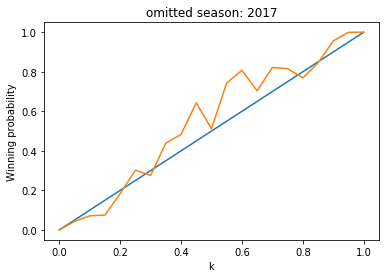

2018
mse: 0.014743280688365137
brier: 0.06772508957863875


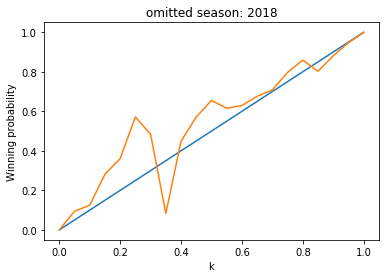

In [41]:
# model 1
x = np.arange(0, 1.01, 0.05)

print("full model")
ses1 = 0
for i in range(len(cv_means1)):
    ses1 += sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)
    
print("")
print("average mse: " + str(ses1/len(cv_means1)))
print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))

print("")
print("simplified model")
ses2 = 0
for i in range(len(cv_means2)):
    ses2 += sum([(cv_means2[i][j]-x[j])**2 for j in range(len(x))]) / len(x)
    
    
print("")
print("average mse: " + str(ses2/len(cv_means2)))
print("average brier score: " + str(sum(cv_briers2)/len(cv_briers2)))

print("")
print("full model graphs")
for i in range(len(cv_means1)):
    print(years[i])
    print("mse: " + str(sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
    print("brier: " + str(cv_briers1[i]))
    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,cv_means1[i])
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    plt.title("omitted season: " + str(years[i]))
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
print("")
print("simplified model graphs")
for i in range(len(cv_means2)):
    print(years[i])
    print("mse: " + str(sum([(cv_means2[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
    print("brier: " + str(cv_briers2[i]))
    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,cv_means2[i])
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    plt.title("omitted season: " + str(years[i]))
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()

### lock and nettleton

In [9]:
means1 = []
briers1 = []
means2 = []
briers2 = []
counts1 = [0 for i in range(21)]
counts2 = [0 for i in range(21)]
cv_means1 = []
cv_means2 = []
cv_briers1 = []
cv_briers2 = []

results1 = []
results2 = []

for i in range(len(train_x)):
    print(i)
    logit_model=sm.Logit(train_y[i], train_x[i])
    result=logit_model.fit()
    results1.append(result)
    
    logit_model=sm.Logit(train_y[i], train_x2[i])
    result=logit_model.fit()
    results2.append(result)

0
Optimization terminated successfully.
         Current function value: 0.448842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.452669
         Iterations 8
1
Optimization terminated successfully.
         Current function value: 0.447119
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.451318
         Iterations 8
2
Optimization terminated successfully.
         Current function value: 0.443935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.447958
         Iterations 8
3
Optimization terminated successfully.
         Current function value: 0.446527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.450675
         Iterations 9
4
Optimization terminated successfully.
         Current function value: 0.445308
         Iterations 8
Optimization terminated successfully.
         Current function value: 0

In [12]:
import math

# check accuracy using the brier score
def check_model_accuracy_times3(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    counts = []
    means = []
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean * cur_num)
        brier += cur_brier
        counts.append(cur_num)

    return y, brier, counts

def check_accuracy_lock_nettleton(x, y, model, start, end):
    cur_means, cur_brier, cur_count = check_model_accuracy_times3(x, y, model, start, end)
    
    return cur_means, cur_brier, cur_count, list(np.divide(np.array(cur_means), np.array(cur_count))), \
        cur_brier / sum(cur_count)

def check_accuracy_lock_nettleton_wrapper(test_x, test_y, results, start, end):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
def check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results, start, end, filename_start):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
    for i in range(len(cv_means1)):
        print(years[i])
        print("mse: " + str(sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
        print("brier: " + str(cv_briers1[i]))
        plt.close()
        plt.plot(x,x) # for reference
        plt.plot(x,cv_means1[i])
        plt.xlabel("k")
        plt.ylabel("Winning probability")
        plt.title("omitted season: " + str(years[i]))
        plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic_time/byseason/"+filename_start+
                    str(years[i])+"_last5.png")
        plt.show()

In [13]:
# full model
print("full model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 15, 0)

# simplified model
print("simplified model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 15, 0)

full model 

full game
average mse: 0.0016243404517787454
average brier score: 0.1484743307456889

1st quarter


/Users/Bill/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Bill/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


average mse: 0.003480364868556956
average brier score: 0.19720544602432985

2nd quarter
average mse: 0.0033892075127834272
average brier score: 0.16801306401652732

3rd quarter
average mse: 0.004493129965629851
average brier score: 0.13542509747238998

4th quarter
average mse: 0.0032461591405158925
average brier score: 0.09941887325131346

simplified model 

full game
average mse: 0.0016409337179698886
average brier score: 0.14970034024023213

1st quarter
average mse: 0.0032279302199383804
average brier score: 0.19827791005509304

2nd quarter
average mse: 0.0034839214925143926
average brier score: 0.16858250924361723

3rd quarter
average mse: 0.0041523880031961525
average brier score: 0.13544854037094686

4th quarter
average mse: 0.00305919900999301
average brier score: 0.10241109741403231



full model

average mse: 0.0016243404517787454
average brier score: 0.1484743307456889

2009
mse: 0.001962992351072252
brier: 0.14087134488607173


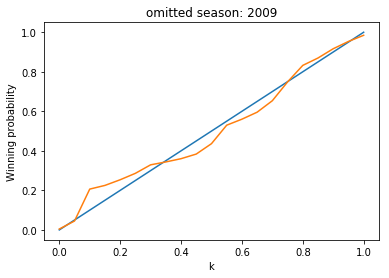

2010
mse: 0.0012950800560595167
brier: 0.14737612879162656


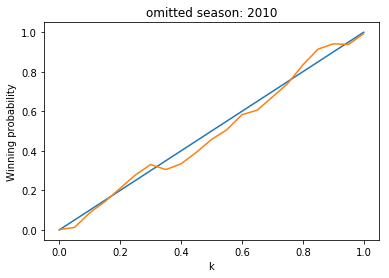

2011
mse: 0.0034016045168692543
brier: 0.15977034425610281


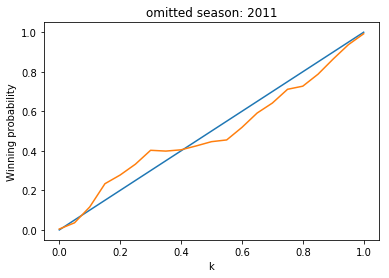

2012
mse: 0.0014961811618371163
brier: 0.15020391862258592


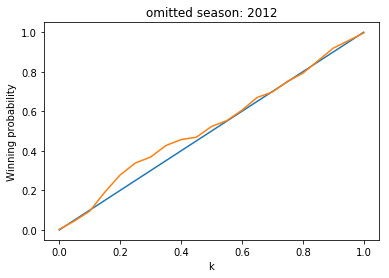

2013
mse: 0.0009856567905099061
brier: 0.1538388700839568


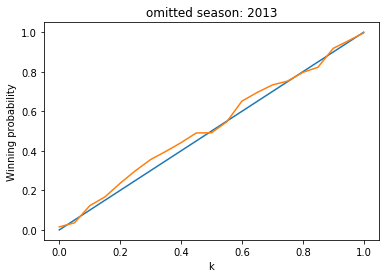

2014
mse: 0.0005794907378240143
brier: 0.14553854661148646


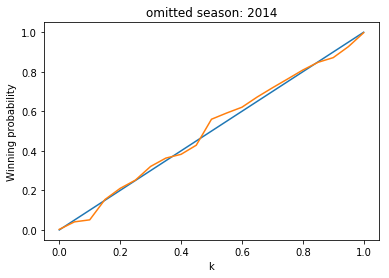

2015
mse: 0.0017163383414954057
brier: 0.15834104777489927


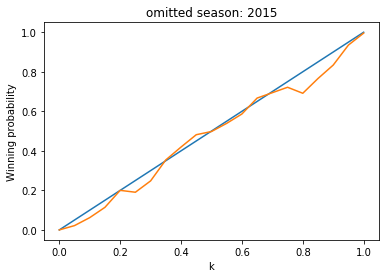

2016
mse: 0.0007535905820452819
brier: 0.15397579961253713


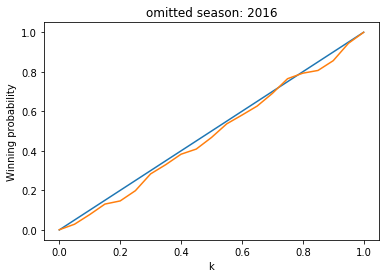

2017
mse: 0.002403751838738271
brier: 0.13077335714889995


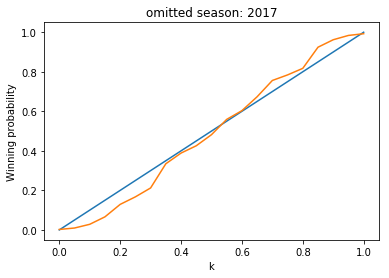

2018
mse: 0.0016487181413364364
brier: 0.14405394966872231


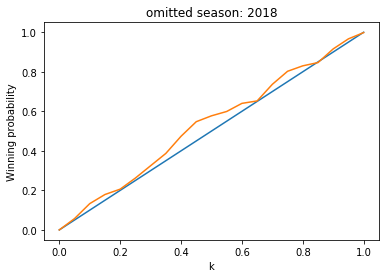

simplified model

average mse: 0.0016409337179698886
average brier score: 0.14970034024023213

2009
mse: 0.0023133741623476765
brier: 0.14259748838122677


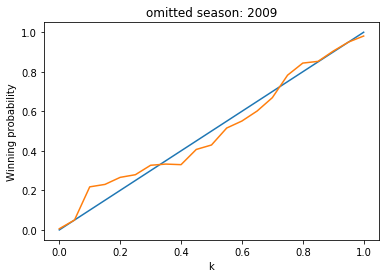

2010
mse: 0.0009880198804843917
brier: 0.1486023123381384


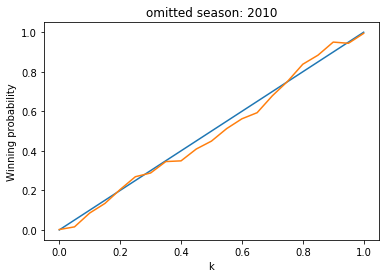

2011
mse: 0.0032488676095819014
brier: 0.16143040449534554


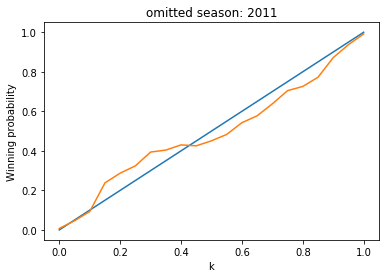

2012
mse: 0.0014328050569735189
brier: 0.15123533060400257


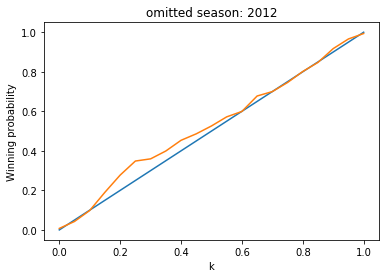

2013
mse: 0.0010276599651068952
brier: 0.15570892426636118


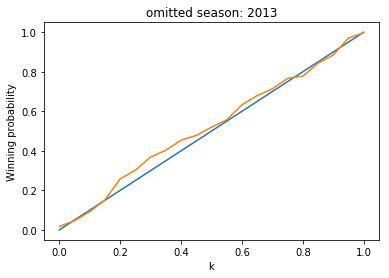

2014
mse: 0.0006757540324730147
brier: 0.14731723177220996


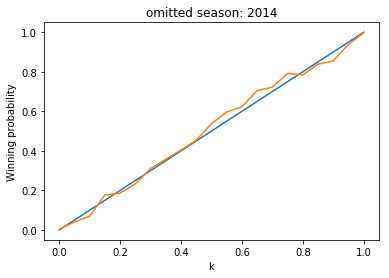

2015
mse: 0.0014540920189619905
brier: 0.1590936452991932


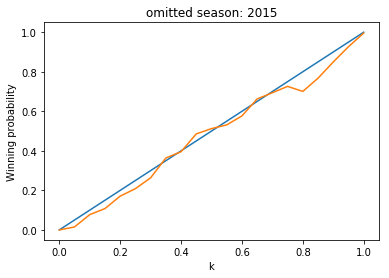

2016
mse: 0.0008928860089294256
brier: 0.15551669059668044


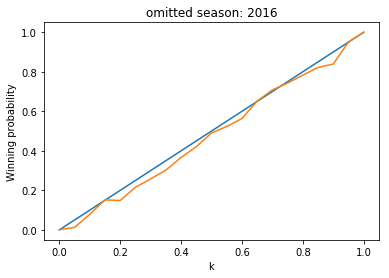

2017
mse: 0.002655964649490288
brier: 0.13148424819208376


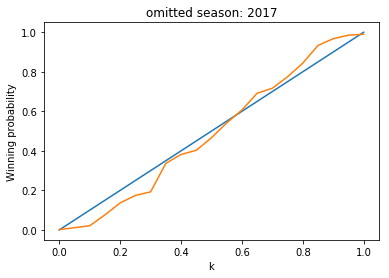

2018
mse: 0.0017199137953497836
brier: 0.14401712645707956


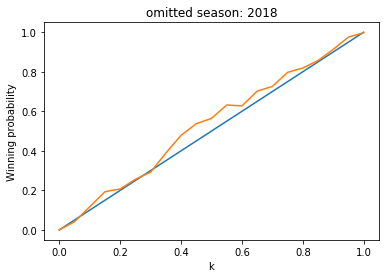

In [11]:
print("full model\n")
check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results1, 60, 0, "full")

print("simplified model\n")
check_accuracy_lock_nettleton_wrapper2(test_x2, test_y, results2, 60, 0, "simplified")

full model

average mse: 0.004669948072867824
average brier score: 0.08490002621303913

2009
mse: 0.004960293776103399
brier: 0.08485013714087675


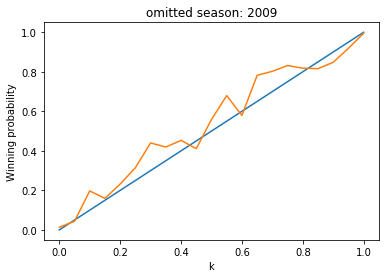

2010
mse: 0.0032412970540404906
brier: 0.08119038653767527


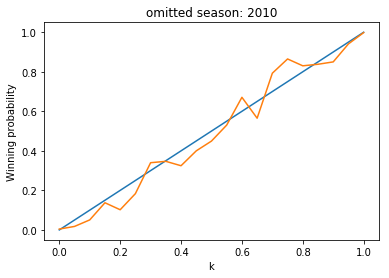

2011
mse: 0.004018431469897836
brier: 0.0833073630060188


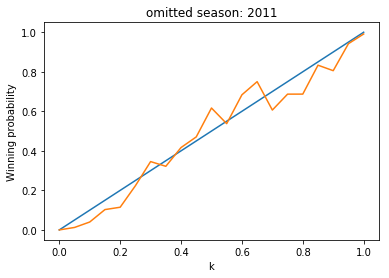

2012
mse: 0.006939697073488062
brier: 0.09176094976493268


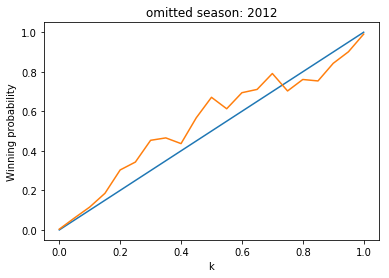

2013
mse: 0.003456241528190953
brier: 0.08808424823079783


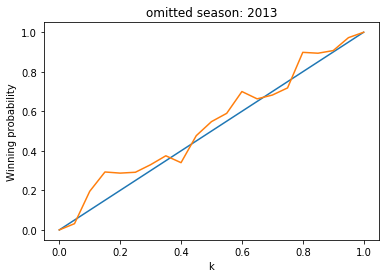

2014
mse: 0.006024269936587927
brier: 0.07177357596472571


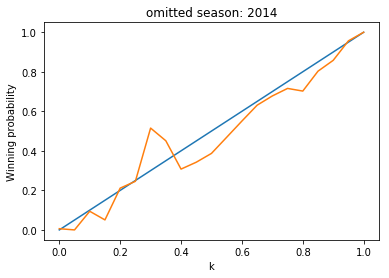

2015
mse: 0.0030984678884671607
brier: 0.09376428568596083


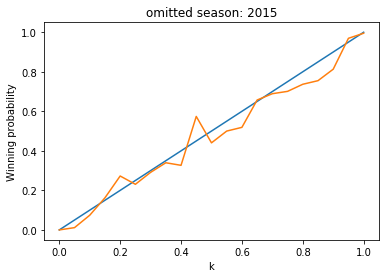

2016
mse: 0.004131256909692821
brier: 0.0856126360325282


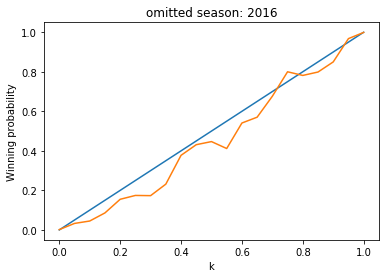

2017
mse: 0.003699384552621186
brier: 0.07414372678387542


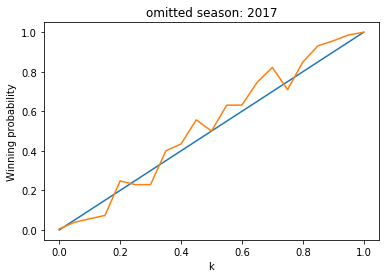

2018
mse: 0.007130140539588406
brier: 0.09451295298299983


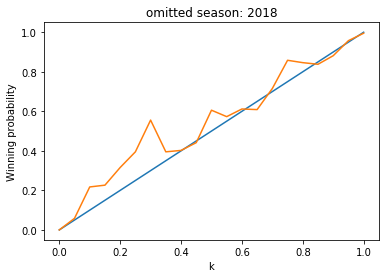

simplified model

average mse: 0.005554754997753192
average brier score: 0.08693631781708065

2009
mse: 0.00703706923438051
brier: 0.08768735730719307


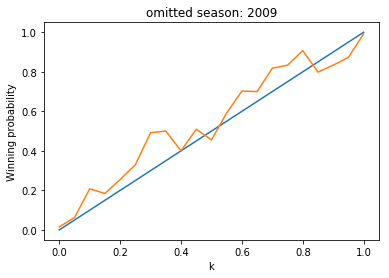

2010
mse: 0.0025784451688400717
brier: 0.08210133872586685


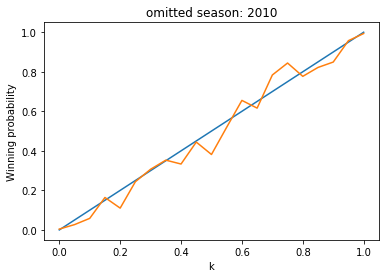

2011
mse: 0.004004072041104205
brier: 0.08627454303429094


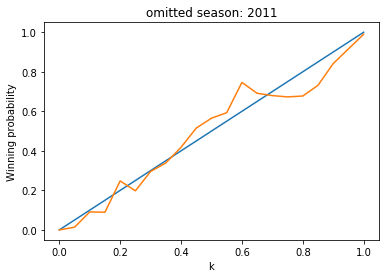

2012
mse: 0.009083109523088554
brier: 0.0935748620616246


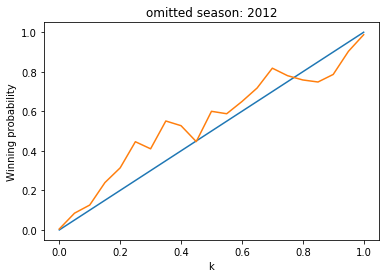

2013
mse: 0.0059383680956799955
brier: 0.08924866680349546


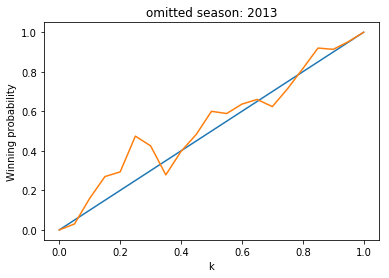

2014
mse: 0.006049309317663476
brier: 0.07289863498228925


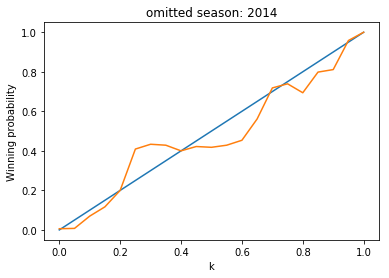

2015
mse: 0.003785477073148013
brier: 0.09689362365641802


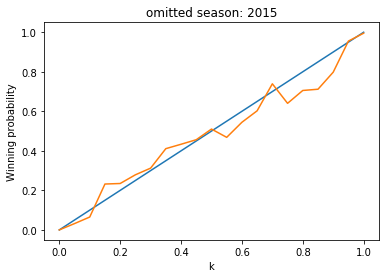

2016
mse: 0.003588552618639503
brier: 0.08791677725630088


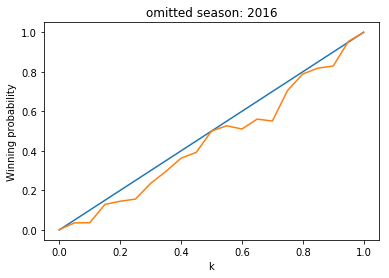

2017
mse: 0.003269134967729564
brier: 0.07481522125741018


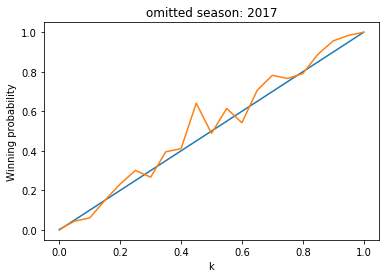

2018
mse: 0.010214011937258034
brier: 0.09795215308591745


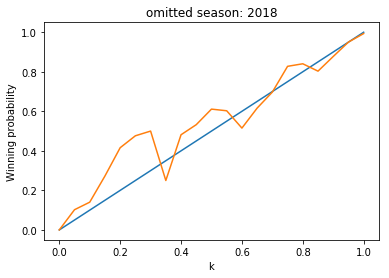

In [13]:
print("full model\n")
check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results1, 5, 0, "full")

print("simplified model\n")
check_accuracy_lock_nettleton_wrapper2(test_x2, test_y, results2, 5, 0, "simplified")

In [ ]:
# shitty code for how i was evaluating earlier

# model 1
x = np.arange(0, 1.01, 0.05)

print("full model")
count = sum(counts1)
result1 = list(map(sum, zip(*means1)))
result1 = list(np.divide(np.array(result1), np.array(counts1)))
brier1 = sum(briers1) / count

for i in range(len(result1)):
    print(str(round(x[i],2)) + ": " + str(round(result1[i],3)))

ses1 = [(result1[i]-x[i])**2 for i in range(len(result1))]
print("")
print("mse: " + str(sum(ses1)/len(ses1)))
print("brier score: " + str(brier1))
    
plt.close()
plt.plot(x,x) # for reference
plt.plot(x,result1)
plt.xlabel("k")
plt.ylabel("Winning probability")
#plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
plt.show()

print("")
# model 2
print("simplified model")
count = sum(counts2)
result2 = list(map(sum, zip(*means2)))
result2 = list(np.divide(np.array(result2), np.array(counts2)))
brier2 = sum(briers2) / count

for i in range(len(result2)):
    print(str(round(x[i],2)) + ": " + str(round(result2[i],3)))

x = np.arange(0, 1.01, 0.05)
ses2 = [(result2[i]-x[i])**2 for i in range(len(result2))]
print("")
print("mse: " + str(sum(ses2)/len(ses2)))
print("brier score: " + str(brier2))
    
plt.close()
plt.plot(x,x) # for reference
plt.plot(x,result2)
plt.xlabel("k")
plt.ylabel("Winning probability")
#plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
plt.show()